In [90]:
#Import Modules

#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

import pandas as pd

#advectionGP
from advectionGP.models import AdjointAdvectionDiffusionReactionModel as Model #Model module builds basic parts of the PDE problem, combines other classes into full model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model

#Plotting tools
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Forward Problem

In [91]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,8,3) # lower time
xloc=np.linspace(2,8,4) # x locations
yloc=np.linspace(2,8,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+1 # upper time

sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging

In [92]:
# generate sensor locations for test data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(2,9,5) # lower time
xloc=np.linspace(1.5,7.5,4) # x locations
yloc=np.linspace(1.5,7.5,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
Xtest= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
Xtest[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] 
Xtest[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1]
Xtest[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2]
Xtest[:,1] = Xtest[:,0]+1

sensorsTest = FixedSensorModel(Xtest,1) # establish sensor model

In [93]:
# Run forward model to generate concentration
#u = [0.05,0.] #Advection


k_0 = 0.01 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,30,30] # grid size for time, x and y
wind=np.cos(np.linspace(0,6*np.pi,res[1]))*0.05
u=[]
u.append(np.ones(res)*wind) #x direction wind
u.append(np.ones(res)*0.0) # y direction wind
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,u=u,k_0=k_0,R=R) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
source=(m.computeSourceFromPhi(z))+5# Compute source
#source[source<0]=0

#source = np.zeros(m.resolution)
##source[0,int(Nx/2)-1,int(Ny/2)-1] = 10.0
#source[:,15:25,15:25] = 5
#source[:,2:7,2:7] = 25
#source[:,7:12,15:20] = 25
#source[:,18:28,10:20] = 25

concTrain=m.computeConcentration(source) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations
concTrainNN=m.computeConcentrationNonNegative(source) # Compute concentration - runs advection diffusion forward model
yTrainNN= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

m.sensormodel=sensorsTest
yTest= m.computeObservations()

print(np.min(concTrain))
print(np.min(yTest))

0.0
5.570772338589107


In [94]:
# Generate training data
###yTrain= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations

yTrain-yTrainNN

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Inverse Problem

In [95]:
N_feat =2000 #Number of features used to infer the source
k = EQ(2, 2.0) 
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,u=u,k_0=k_0,R=R) #Initiate new model for inference
regress = mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio

meanZNN, covZNN = mInfer.computeZDistribution(yTrainNN) # Infers z vector mean and covariance
sourceInferNN = mInfer.computeSourceFromPhi(meanZNN) # Generates estimated source using inferred distributio

Calculating Adjoints...
47/48 
Calculating Phis...
1999/2000 


In [96]:
(np.square(np.subtract(source,sourceInfer))).mean() #MSE between ground truth and inferred source

2.8117358280443527

In [97]:
(np.square(np.subtract(source,sourceInferNN))).mean() #MSE between ground truth and inferred source

2.8117358280443527

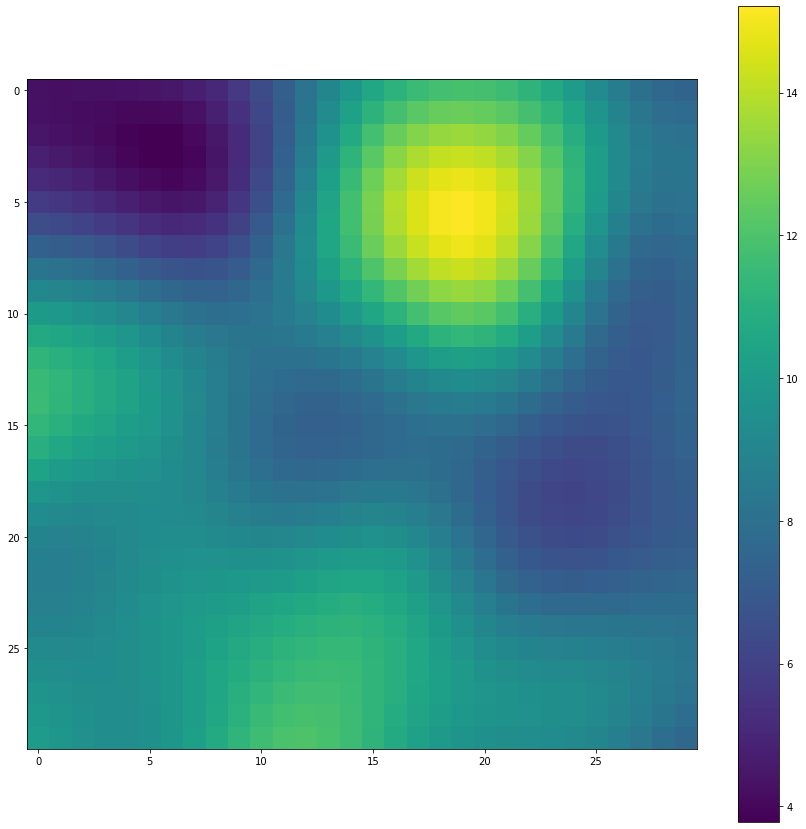

In [98]:
plt.imshow(concTrain[10])
plt.colorbar()

## Plot sources for comparison

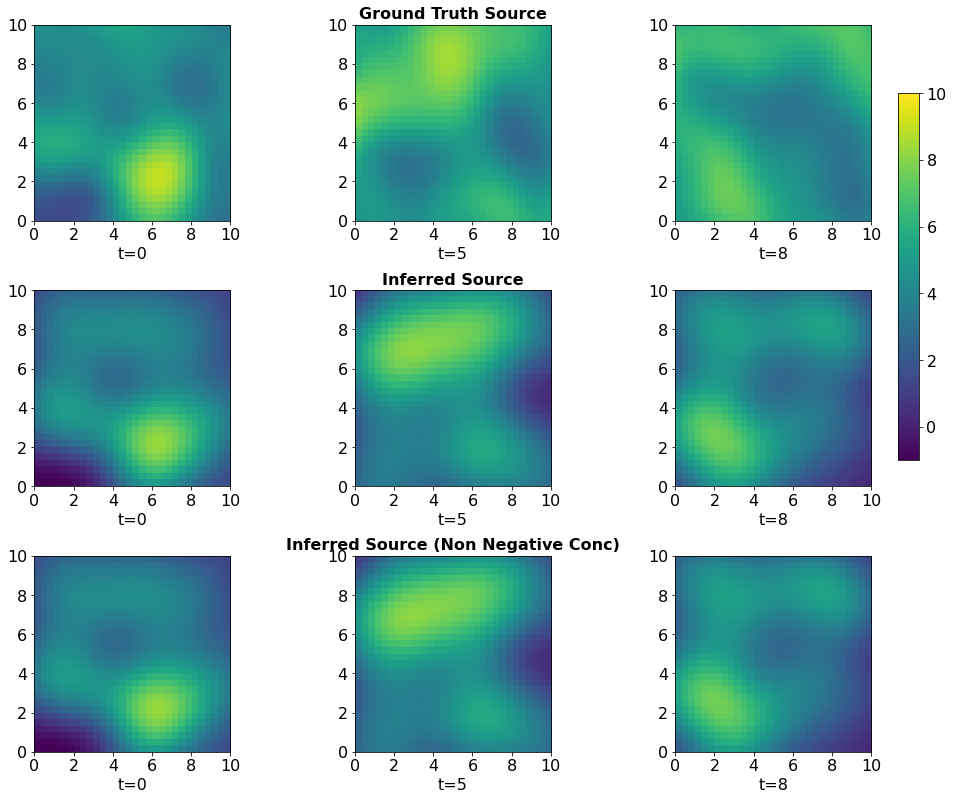

In [99]:
a=np.floor(np.min((np.min(sourceInfer),np.min(source))))
b=np.ceil(np.max((np.max(sourceInfer),np.max(source))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

plt.subplot(331)
im1=plt.imshow(source[0], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=0",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im1,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(332)
im2=plt.imshow(source[16], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=5",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im2,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)
plt.title('Ground Truth Source', fontsize=16, fontweight='bold')

plt.subplot(333)
im3=plt.imshow(source[39], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=8",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)

plt.subplot(334)
im1=plt.imshow(sourceInfer[0], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=0",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im1,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(335)
im4=plt.imshow(sourceInfer[16], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=5",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im2,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)
plt.title('Inferred Source', fontsize=16, fontweight='bold')

plt.subplot(336)
im3=plt.imshow(sourceInfer[39], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=8",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)

plt.subplot(337)
im1=plt.imshow(sourceInferNN[0], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=0",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im1,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(338)
im4=plt.imshow(sourceInferNN[16], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=5",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im2,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)
plt.title('Inferred Source (Non Negative Conc)', fontsize=16, fontweight='bold')

plt.subplot(339)
im3=plt.imshow(sourceInferNN[39], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=8",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)

fig.tight_layout(rect=[0.1, 0.2, 1, 0.95])


fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.97, 0.52, 0.02, 0.34])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

In [100]:
N_feat =200 #Number of features used to infer the source
k = EQ(2, 2.0) 
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,u=u,k_0=k_0,R=R) #Initiate new model for inference
X1 = mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
reps=100
llObs=0
llObsNN=0
MSE=0
MSENN=0
cMSE=0
cMSENN=0
negPercent=0
var = np.ones(len(yTest))*noiseSD**2
for j in range(reps):
    mInfer.sensormodel=sensors
    z = np.random.multivariate_normal(meanZ,covZ)
    source = mInfer.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
    conc=mInfer.computeConcentrationNonNegative(source) # Compute test concentration
    mInfer.sensormodel=sensorsTest
    yInfer= mInfer.computeObservations(addNoise='TRUE') # Compute observations with noise
    llObsNN += 0.5*np.sum((np.square(np.subtract(yTest,yInfer))/var)+0.5*np.log(var))
    MSENN += (np.square(np.subtract(yTest,yInfer))).mean() 
    cMSENN += (np.square(np.subtract(conc,concTrain))).mean() 
llObsNN = llObsNN/reps
MSENN = MSENN/reps
cMSENN = cMSENN/reps

for j in range(reps):
    mInfer.sensormodel=sensors
    z = np.random.multivariate_normal(meanZ,covZ)
    source = mInfer.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
    conc=mInfer.computeConcentration(source) # Compute test concentration
    if np.min(conc) < 0:
        negPercent+=1
    mInfer.sensormodel=sensorsTest
    yInfer= mInfer.computeObservations(addNoise='TRUE') # Compute observations with noise
    llObs += 0.5*np.sum((np.square(np.subtract(yTest,yInfer))/var)+0.5*np.log(var))
    MSE += (np.square(np.subtract(yTest,yInfer))).mean() 
    cMSE += (np.square(np.subtract(conc,concTrain))).mean() 
llObs = llObs/reps
MSE=MSE/reps
cMSE=cMSE/reps
print(negPercent)

Calculating Adjoints...
47/48 
Calculating Phis...
199/200 
94


In [101]:
llObs

47446.75789939096

In [102]:
llObsNN

48103.74507919851

In [103]:
MSE

2.9729116993958216

In [104]:
MSENN

3.0139733981337917

In [105]:
cMSE

32.460742006133735

In [106]:
cMSENN

33.83987299218913

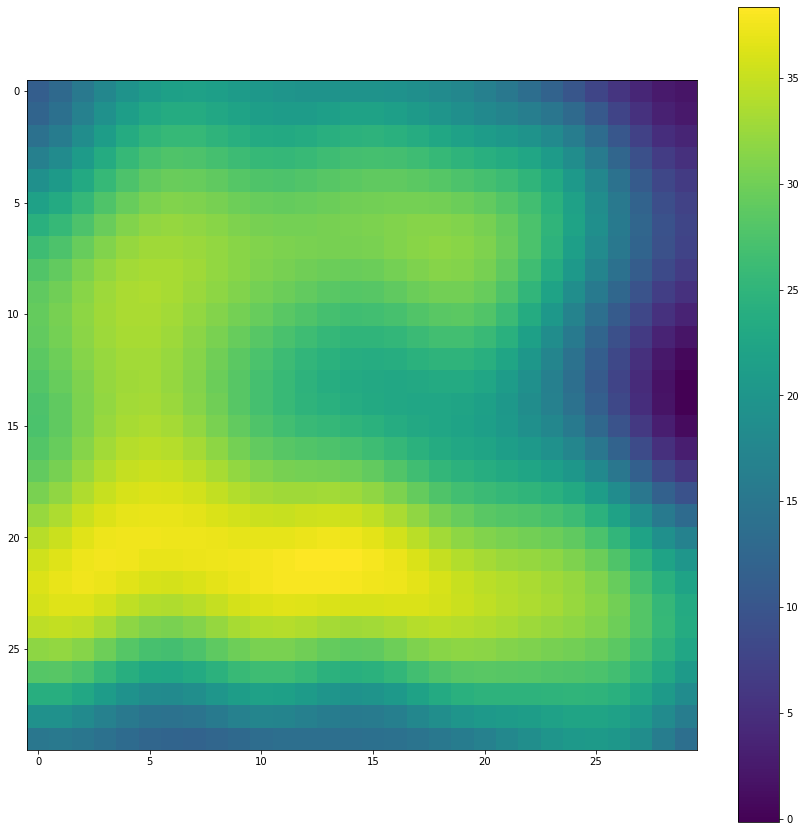

In [107]:
plt.imshow(conc[40])
plt.colorbar()

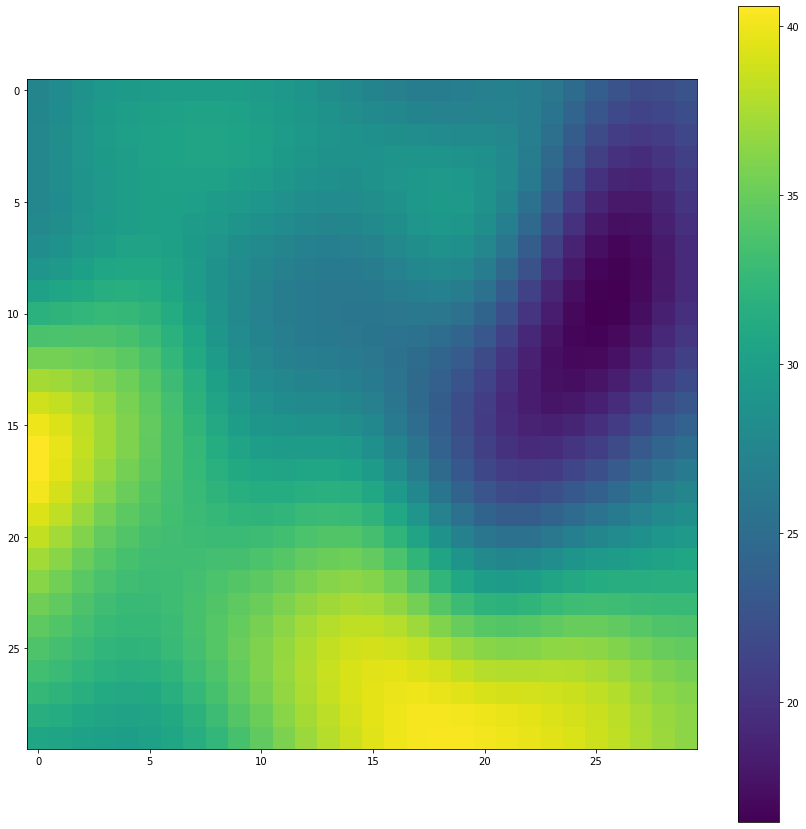

In [108]:
plt.imshow(concTrain[40])
plt.colorbar()

In [109]:
np.min(conc)

-1.1991307864194065